# 1 layer, 3 vs 9, few training samples

# Classification of MNIST binary dataset using MPS encoding

In [37]:
from functions import *
from MPS_functions import *

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from sklearn import svm
import math

np.random.seed(88)

## Import MNIST dataset

In [38]:
with np.load('mnist.npz', allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

# Rescale the images from [0,255] to the [0,1] range.
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


### We filter only two classes for binary classification

We choose two numbers: number_0 and number_1 

In [39]:
number_0 = 3; number_1 = 9 

In [40]:
def filter_01(x, y, number_0, number_1):
    keep = (y == number_0) | (y == number_1)
    x, y = x[keep], y[keep]
    return x,y

In [41]:
x_train, y_train = filter_01(x_train, y_train, number_0, number_1)
x_test, y_test = filter_01(x_test, y_test, number_0, number_1)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12080
Number of filtered test examples: 2019


Labels must be 0's and 1's

In [42]:
y_test = np.where(y_test == number_0, 0, y_test)
y_test = np.where(y_test == number_1, 1, y_test)
y_test = np.array(y_test, requires_grad=False)

y_train = np.where(y_train == number_0, 0, y_train)
y_train = np.where(y_train == number_1, 1, y_train)
y_train = np.array(y_train, requires_grad=False)

Take random training and test subsets

In [43]:
def random_subset(x, y, n):
    indices = np.random.choice(len(x), n, replace=False)
    return x[indices], y[indices]

# Set your desired number of samples
n_train = 1000
n_test = 2000

x_train, y_train = random_subset(x_train, y_train, n_train)
x_test, y_test = random_subset(x_test, y_test, n_test)

print(x_train.shape)
print(x_test.shape)

(1000, 28, 28)
(2000, 28, 28)


## Create the superposition state 

We need $L=\left \lceil{\log_2(28\times 28)}\right \rceil = 10$ qubits for the image loading. We define the 10-qubit quantum state:
$$
\begin{align}
|\psi\rangle=\frac{|z\rangle + |W\rangle}{\sqrt{2}}
\end{align}
$$

Where:\
$\bullet |z\rangle =$ image from left to right and up to down\
$\bullet |W\rangle =$ image from up to down and left to right


In [44]:
# Create unnormalized |z> and |W>
def encode_mnist_states(images, reading_order="left_to_right_up_to_down"):
    n_samples, n_rows, n_cols = images.shape

    encoding_qubits=math.ceil(math.log2(n_rows*n_cols))
    state_dim = 2 ** encoding_qubits  

    encoded_states = np.zeros((n_samples, state_dim))

    for i, image in enumerate(images):
        state = np.zeros(state_dim)
        index = 0

        if reading_order == "left_to_right_up_to_down":
            for row in range(n_rows):
                for col in range(n_cols):
                    state[index] = image[row, col]
                    index += 1
        elif reading_order == "up_to_down_left_to_right":
            for col in range(n_cols):
                for row in range(n_rows):
                    state[index] = image[row, col]
                    index += 1
        else:
            raise ValueError("Invalid reading_order. Choose 'left_to_right_up_to_down' or 'up_to_down_left_to_right'.")

        encoded_states[i, :] = state

    return encoded_states

train_left_right = encode_mnist_states(x_train, reading_order="left_to_right_up_to_down")
train_up_down = encode_mnist_states(x_train, reading_order="up_to_down_left_to_right")

test_left_right = encode_mnist_states(x_test, reading_order="left_to_right_up_to_down")
test_up_down = encode_mnist_states(x_test, reading_order="up_to_down_left_to_right")


# Create the superposition quantum state
def create_normalized_vectors(encoded_states_left_right, encoded_states_up_down):
    normalized_vectors = []
    for i in range(len(encoded_states_left_right)):
        left_right = encoded_states_left_right[i]
        up_down = encoded_states_up_down[i]
        
        # Sum the corresponding elements from both arrays
        combined = np.add(left_right, up_down)
        
        # Normalization
        l2_norm = np.linalg.norm(combined, ord=2)
        normalized_vector = combined / l2_norm
        
        normalized_vectors.append(normalized_vector)
    
    return np.array(normalized_vectors, requires_grad = False)

The training and test sets containing the superposition quantum states $|\psi\rangle$ of the images:

In [45]:
training_states = create_normalized_vectors(train_left_right, train_up_down)
test_states = create_normalized_vectors(test_left_right, test_up_down)

## Clasical benchmark using these arrays to perform classification

We are using state $|\psi\rangle$ as input for the clasical model

This linear model uses a numper of parameters p=n_features+1\
In our case this is 1024+1=1025 trainable parameters

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Replace with your data loading code
X_train = training_states
X_test = test_states

# Create a LogisticRegression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9665


## Using the MPS approximation of the image states

We will use the approximated states

$$
\begin{align}
|\tilde{\psi}\rangle=\text{MPS}_\chi (|\psi\rangle)
\end{align}
$$

where $\chi$ is the bond dimension which controls the degree of compression of the image.

Take an example

In [47]:
def norm_2(exact,approximate):
    length = len(exact)
    sum = 0
    for i in range(length):
        sum = sum + (exact[i]-approximate[i])**2
    return np.sqrt(sum/length)[0]

def fidelity(exact,approximate):
    return np.abs(exact @ approximate)**2

In [48]:
L = 10; d = 2; chis = [1,2,4,8,16,32]

# We take an element of the training set as an example
state = training_states[0]

for chi in chis:
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fid = fidelity(state,approx_state)
    L2_norm = norm_2(state,approx_state)
    print('Chi ='+ str(chi))
    print('Fidelity: ', fid[0])
    print('L2 norm: ', L2_norm)
    print('')

Chi =1
Fidelity:  0.26938966383054375
L2 norm:  0.03064961976767334

Chi =2
Fidelity:  0.4329252552066784
L2 norm:  0.0258462038583748

Chi =4
Fidelity:  0.7252576143587157
L2 norm:  0.017023617485813113

Chi =8
Fidelity:  0.9144238715711407
L2 norm:  0.009243332804952143

Chi =16
Fidelity:  0.9975186082969193
L2 norm:  0.0015571574105562739

Chi =32
Fidelity:  1.0000000000000027
L2 norm:  1.0175162965938628e-16



Now we choose a $\chi$ and we obtain the correspondent approximated training and test sets

In [49]:
chi = 1

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

Clasical benchmark with the approximation state $|\tilde{\psi}\rangle$

In [50]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.796


In [51]:
save_1 = training_approx_states[0]

To ensure that Pennylane does not try to compute the grad:

In [52]:
x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

# Variational model 

In [53]:
# Number of layes of the model
# The number of trainabla parameters will be 3*layers*loading_qubits
layers = 1

Here we present the variational quantum circuit which will be used as QNN\
We assume it is initialized with $|\tilde{\psi}\rangle$ loaded in the amplitudes

In [55]:
# We need L = 10 qubits to encode the image using MPS and one extra qubit to perform classification

loading_qubits = int(np.log2(len(training_states[0])))
qubits = int(loading_qubits+1) 

dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev, interface="autograd")
def QNN(params, x, y):
    loading_qubits = int(np.log2(len(x)))
    layers = np.shape(params)[0]//loading_qubits

    qml.AmplitudeEmbedding(x, wires=list(range(loading_qubits)))

    for j in range(layers):
        for p in range(loading_qubits):
            qml.CRot(params[j*loading_qubits+p][0],params[j*loading_qubits+p][1],params[j*loading_qubits+p][2], wires=[p,loading_qubits])

    return qml.expval(qml.Hermitian(y, wires=[loading_qubits]))

The classification qubits assigns labels according to the fidelity with respect to the label states $|0\rangle$ and $|1\rangle$

In [56]:
label_0 = [[1,0],[0,0]]
label_1 = [[0,0],[0,1]]
dm_labels = [label_0, label_1]
dm_labels = np.array(dm_labels, requires_grad=False)

In [58]:
def cost(params, x, y, dm_labels):
    loss = 0.0
    
    for i in range(len(x)):
        f = QNN(params, x[i], dm_labels[int(y[i])])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def test(params, x, y, dm_labels):
    fidelity_values = []
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: QNN(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels] 
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

Training:

In [59]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 5
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

for it in range(epochs): 
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): 
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.217134 | Train accuracy: 0.717000 | Test accuracy: 0.694500
Epoch:  2 | Loss: 0.212261 | Train accuracy: 0.734000 | Test accuracy: 0.695500
Epoch:  3 | Loss: 0.211097 | Train accuracy: 0.731000 | Test accuracy: 0.702000
Epoch:  4 | Loss: 0.210846 | Train accuracy: 0.739000 | Test accuracy: 0.710500
Epoch:  5 | Loss: 0.211266 | Train accuracy: 0.747000 | Test accuracy: 0.715500


## $\chi=2$

In [61]:
chi = 2

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

Classical benchmark:

In [62]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9375


In [64]:
np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

for it in range(epochs): 
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): 
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.186869 | Train accuracy: 0.849000 | Test accuracy: 0.875000
Epoch:  2 | Loss: 0.183763 | Train accuracy: 0.844000 | Test accuracy: 0.865000
Epoch:  3 | Loss: 0.183046 | Train accuracy: 0.848000 | Test accuracy: 0.866000
Epoch:  4 | Loss: 0.182757 | Train accuracy: 0.846000 | Test accuracy: 0.866000
Epoch:  5 | Loss: 0.182817 | Train accuracy: 0.847000 | Test accuracy: 0.868500


## $\chi=3$

In [66]:
chi = 3

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))


for it in range(epochs): 
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.193171 | Train accuracy: 0.836000 | Test accuracy: 0.866500
Epoch:  2 | Loss: 0.188398 | Train accuracy: 0.848000 | Test accuracy: 0.873500
Epoch:  3 | Loss: 0.186183 | Train accuracy: 0.854000 | Test accuracy: 0.882500
Epoch:  4 | Loss: 0.185192 | Train accuracy: 0.863000 | Test accuracy: 0.890000
Epoch:  5 | Loss: 0.184304 | Train accuracy: 0.867000 | Test accuracy: 0.892500


In [67]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9525


## $\chi=4$

In [68]:
chi = 4

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))


for it in range(epochs): 
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.193353 | Train accuracy: 0.864000 | Test accuracy: 0.885500
Epoch:  2 | Loss: 0.187446 | Train accuracy: 0.883000 | Test accuracy: 0.893000
Epoch:  3 | Loss: 0.187585 | Train accuracy: 0.888000 | Test accuracy: 0.905000
Epoch:  4 | Loss: 0.187474 | Train accuracy: 0.886000 | Test accuracy: 0.905500
Epoch:  5 | Loss: 0.186901 | Train accuracy: 0.888000 | Test accuracy: 0.906500


In [69]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.958


## $\chi=32$

In [70]:
chi = 32

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

In [71]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 20
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.186045 | Train accuracy: 0.934000 | Test accuracy: 0.938500
Epoch:  2 | Loss: 0.173697 | Train accuracy: 0.933000 | Test accuracy: 0.948500
Epoch:  3 | Loss: 0.167176 | Train accuracy: 0.947000 | Test accuracy: 0.958000
Epoch:  4 | Loss: 0.166484 | Train accuracy: 0.948000 | Test accuracy: 0.957000
Epoch:  5 | Loss: 0.166608 | Train accuracy: 0.946000 | Test accuracy: 0.957500
Epoch:  6 | Loss: 0.166744 | Train accuracy: 0.945000 | Test accuracy: 0.954500
Epoch:  7 | Loss: 0.166837 | Train accuracy: 0.945000 | Test accuracy: 0.954500
Epoch:  8 | Loss: 0.166898 | Train accuracy: 0.946000 | Test accuracy: 0.953500
Epoch:  9 | Loss: 0.166938 | Train accuracy: 0.945000 | Test accuracy: 0.953500
Epoch: 10 | Loss: 0.166966 | Train accuracy: 0.946000 | Test accuracy: 0.953000
Epoch: 11 | Loss: 0.166987 | Train accuracy: 0.946000 | Test accuracy: 0.952500
Epoch: 12 | Loss: 0.167003 | Train accur

In [72]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9665


## Test accuracies vs. bond dimension

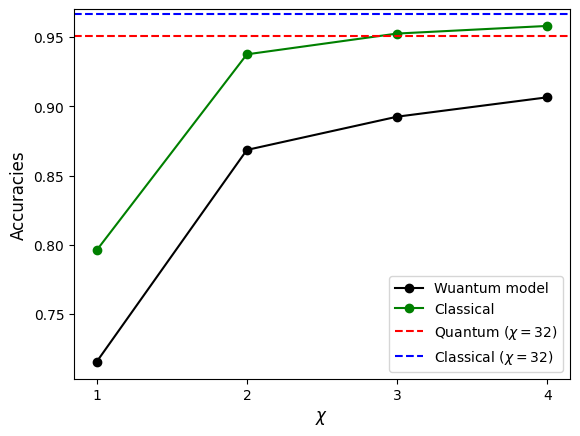

In [76]:
import matplotlib.pyplot as plt

chis = [1, 2, 3, 4]
classical = [0.796, 0.9375, 0.9525, 0.958]
quantum_model = [0.7155, 0.8685, 0.8925, 0.9065]

quantum_line = 0.9505
classical_line = 0.9665

plt.plot(chis, quantum_model, marker='o', label='Wuantum model', color='black')
plt.plot(chis, classical, marker='o', label='Classical', color='green')

plt.axhline(quantum_line, color='r', linestyle='--', label=r'Quantum ($\chi=32$)')
plt.axhline(classical_line, color='b', linestyle='--', label=r'Classical ($\chi=32$)')

plt.xlabel(r'$\chi$', fontsize=12)
plt.ylabel('Accuracies', fontsize=12)
plt.legend()

plt.xticks(chis)

plt.show()
